In [1]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.graphics.tsaplots as sgt
from statsmodels.tsa.arima_model import ARMA
import statsmodels.tsa.stattools as sts 
import seaborn as sns
from statsmodels.tsa.api import ExponentialSmoothing

import warnings
warnings.filterwarnings('ignore')
# dickey fuller test for stationarity check
from statsmodels.tsa.stattools import adfuller,acf,pacf
from statsmodels.tsa.statespace.tools import diff

# pip install pmdarima
from pmdarima.arima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

from sklearn.metrics import mean_squared_error
import statsmodels.api as sm

# TASK1

### Load the Data

In [2]:
df=pd.read_csv("DS3_C1_S3_SuperstoreSales_Data_Challenge.csv", parse_dates=['Order Date']).set_index('Order Date')
df.head()

,Row ID,Order ID,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,State,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
Order Date,,,,,,,,,,,,,,,,,,,,
2016-08-11,1,CA-2016-152156,11-11-2016,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600,2,0.00,41.9136
2016-08-11,2,CA-2016-152156,11-11-2016,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400,3,0.00,219.5820
2016-12-06,3,CA-2016-138688,16-06-2016,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,California,90036,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200,2,0.00,6.8714
2015-11-10,4,US-2015-108966,18-10-2015,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,Florida,33311,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775,5,0.45,-383.0310
2015-11-10,5,US-2015-108966,18-10-2015,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,Florida,33311,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680,2,0.20,2.5164


In [3]:
df = df[['Sales']]
df.head(5)

,Sales
Order Date,
2016-08-11,261.9600
2016-08-11,731.9400
2016-12-06,14.6200
2015-11-10,957.5775
2015-11-10,22.3680


In [4]:
df.isna().sum()

Sales    0
dtype: int64

#### Exploring Daily Mean Temprature of Delhi

In [5]:
sales_df=df.sort_values(by=['Order Date'])
print(sales_df.head(5))

              Sales
Order Date         
2014-01-02  468.900
2014-01-03  634.116
2014-01-03  362.250
2014-01-03   63.552
2014-01-03    5.940


In [6]:
sales_df=sales_df.resample('M').mean()
print(sales_df.head(5))

                 Sales
Order Date            
2014-01-31  221.020656
2014-02-28  148.175674
2014-03-31  326.201821
2014-04-30  204.215008
2014-05-31  200.269149


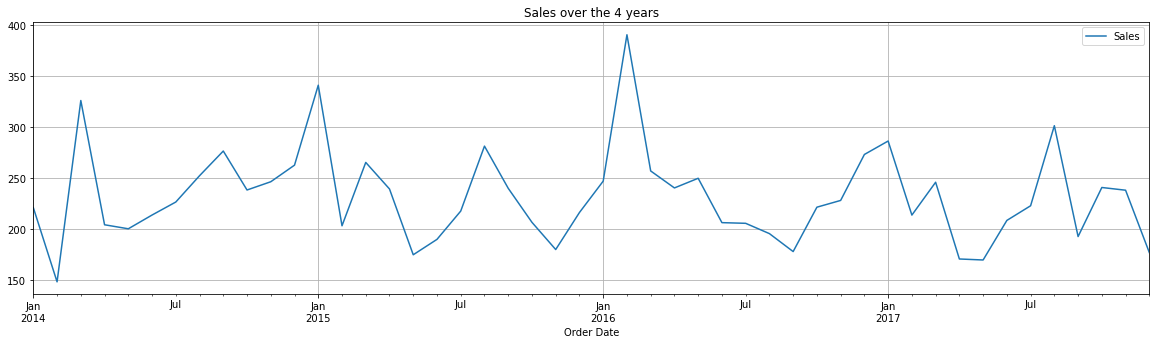

In [7]:
sales_df.plot(figsize=(20, 5))
plt.grid()
plt.legend(loc='best')
plt.title('Sales over the 4 years')
plt.show(block=False)

### Checking for Outliers

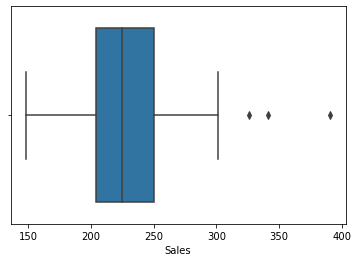

In [8]:
sns.boxplot(x=sales_df['Sales'],whis=1.5);

### Decomposing the Data - To visualize the Different Components of the Daily Data

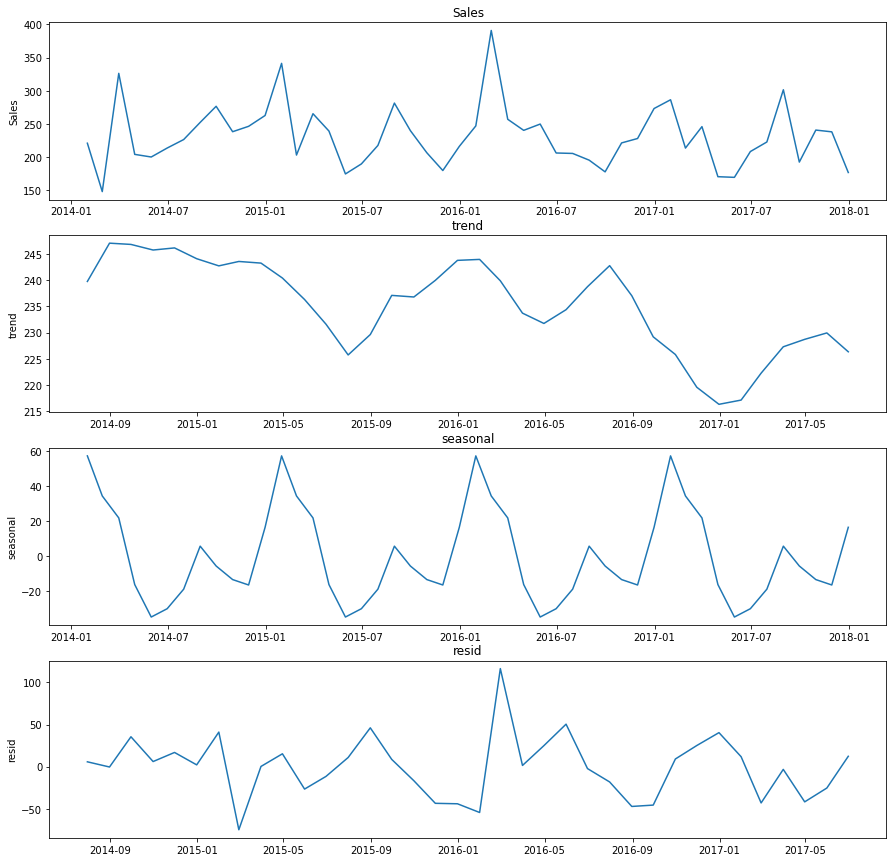

In [9]:
df.sort_index(inplace=True)
decomposition = seasonal_decompose(sales_df, model='additive',period=12)

dt=decomposition.trend
ds=decomposition.seasonal
dr=decomposition.resid

a= [sales_df['Sales'],dt,ds,dr]

# Trend
fig , axes =plt.subplots(4,1, figsize=(15,15))
for i ,ax in zip(a,axes.flatten()):
    ax.plot(i)
    ax.set_ylabel(i.name)
    ax.set_title(i.name)

# TASK2

### To check if Data is Stationary 

In [10]:
pvalue = adfuller(sales_df)[1]

if(pvalue>0.05):
    print('p-value={}. Data is not stationary'.format(pvalue))
else:
    print('p-value={}. Data is stationary'.format(pvalue))

p-value=1.4097136094620606e-07. Data is stationary


# TASK3

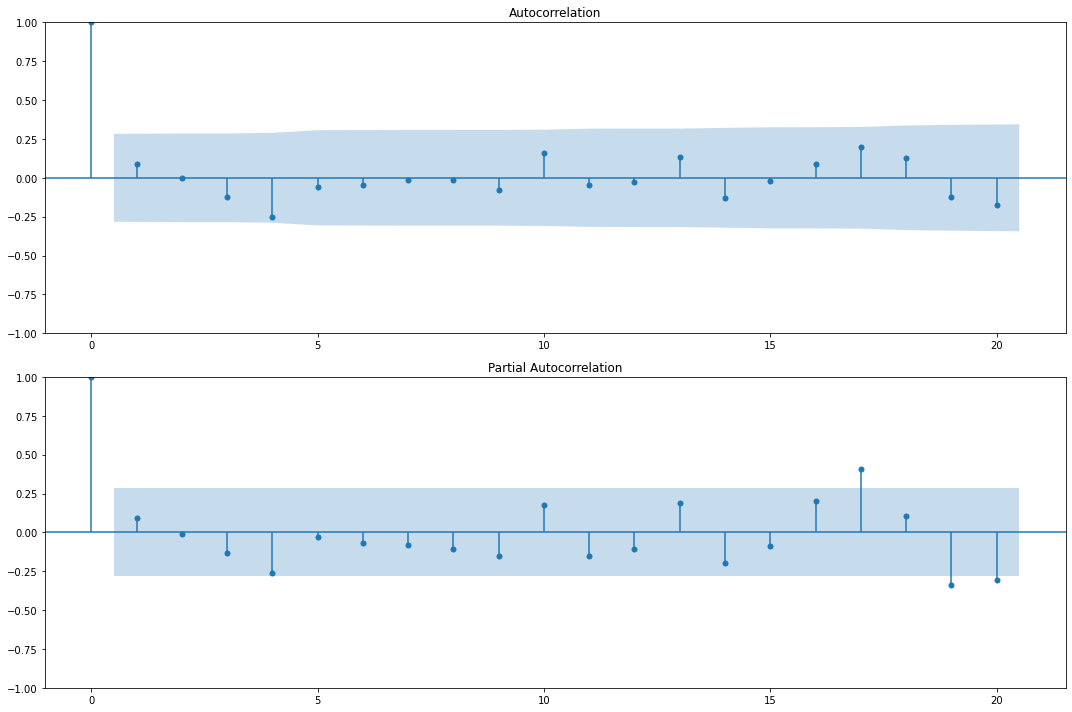

In [11]:
fig = plt.figure(figsize=(15, 10))

# Show ACF
ax1 = fig.add_subplot(211)
sm.graphics.tsa.plot_acf(sales_df, lags=20, ax=ax1)

# Show PACF
ax2 = fig.add_subplot(212)
sm.graphics.tsa.plot_pacf(sales_df, lags=20, ax=ax2)

plt.tight_layout()

#### From above Correlogram we got the value of P(0) and Q(0) so we will take random p and q up to three

### Test Train Split

In [12]:
# split the data into train and test
ss = int(0.8 * len(sales_df))

train = sales_df.iloc[:ss]
test = sales_df.iloc[ss:]
print("train = {}, test = {}".format(len(train), len(test)))

train = 38, test = 10


### AR Model

In [13]:
ar_m1 = ARIMA(train,order=(1,0,0)).fit()
print(ar_m1.summary())

                               SARIMAX Results                                
Dep. Variable:                  Sales   No. Observations:                   38
Model:                 ARIMA(1, 0, 0)   Log Likelihood                -199.994
Date:                Mon, 26 Dec 2022   AIC                            405.988
Time:                        11:04:25   BIC                            410.901
Sample:                    01-31-2014   HQIC                           407.736
                         - 02-28-2017                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        235.8948     10.432     22.612      0.000     215.448     256.341
ar.L1          0.0931      0.182      0.512      0.609      -0.263       0.450
sigma2      2181.6530    445.346      4.899      0.0

In [14]:
ar_m2 = ARIMA(train,order=(2,0,0)).fit()
print(ar_m2.summary())

                               SARIMAX Results                                
Dep. Variable:                  Sales   No. Observations:                   38
Model:                 ARIMA(2, 0, 0)   Log Likelihood                -199.963
Date:                Mon, 26 Dec 2022   AIC                            407.925
Time:                        11:04:25   BIC                            414.475
Sample:                    01-31-2014   HQIC                           410.256
                         - 02-28-2017                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        235.9433     10.044     23.491      0.000     216.258     255.629
ar.L1          0.0972      0.180      0.539      0.590      -0.256       0.450
ar.L2         -0.0425      0.275     -0.155      0.8

In [29]:
ar_m3 = ARIMA(train,order=(3,0,0)).fit()
print(ar_m3.summary())

                               SARIMAX Results                                
Dep. Variable:                  Sales   No. Observations:                   38
Model:                 ARIMA(3, 0, 0)   Log Likelihood                -199.623
Date:                Mon, 26 Dec 2022   AIC                            409.245
Time:                        11:05:17   BIC                            417.433
Sample:                    01-31-2014   HQIC                           412.158
                         - 02-28-2017                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        235.8029      8.932     26.400      0.000     218.297     253.309
ar.L1          0.0937      0.181      0.519      0.604      -0.260       0.448
ar.L2         -0.0144      0.257     -0.056      0.9

### Checking Goodness of Model

In [15]:
# LJung-Box test
pvalue = sm.stats.acorr_ljungbox(ar_m1.resid,lags=[1],return_df=True)['lb_pvalue'].values
if pvalue < 0.05:
    print("Reject H0. Bad model")
else:
    print("Fail-to-Reject H0. Good model")

Fail-to-Reject H0. Good model


## MA Model

In [30]:
ma_M1 = ARIMA(train,order=(0,0,1)).fit()

In [31]:
print(ma_M1.summary())

                               SARIMAX Results                                
Dep. Variable:                  Sales   No. Observations:                   38
Model:                 ARIMA(0, 0, 1)   Log Likelihood                -199.986
Date:                Mon, 26 Dec 2022   AIC                            405.971
Time:                        11:05:38   BIC                            410.884
Sample:                    01-31-2014   HQIC                           407.719
                         - 02-28-2017                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        235.8661     10.394     22.693      0.000     215.495     256.237
ma.L1          0.0969      0.181      0.534      0.593      -0.259       0.453
sigma2      2180.7467    446.980      4.879      0.0

In [32]:
ma_M2 = ARIMA(train,order=(0,0,2)).fit()
print(ma_M2.summary())

                               SARIMAX Results                                
Dep. Variable:                  Sales   No. Observations:                   38
Model:                 ARIMA(0, 0, 2)   Log Likelihood                -199.981
Date:                Mon, 26 Dec 2022   AIC                            407.963
Time:                        11:05:40   BIC                            414.513
Sample:                    01-31-2014   HQIC                           410.294
                         - 02-28-2017                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        235.9358     10.181     23.174      0.000     215.981     255.890
ma.L1          0.0921      0.183      0.504      0.614      -0.266       0.450
ma.L2         -0.0205      0.280     -0.073      0.9

### Checking Goodness of Model

In [33]:
# LJung-Box test
pvalue = sm.stats.acorr_ljungbox(ma_M1.resid,lags=[1],return_df=True)['lb_pvalue'].values
if pvalue < 0.05:
    print("Reject H0. Bad model")
else:
    print("Fail-to-Reject H0. Good model")

Fail-to-Reject H0. Good model


## ARMA Model

In [34]:
m1 = ARIMA(train,order=(1,0,1)).fit()
print(m1.summary())

                               SARIMAX Results                                
Dep. Variable:                  Sales   No. Observations:                   38
Model:                 ARIMA(1, 0, 1)   Log Likelihood                -199.985
Date:                Mon, 26 Dec 2022   AIC                            407.970
Time:                        11:06:53   BIC                            414.520
Sample:                    01-31-2014   HQIC                           410.300
                         - 02-28-2017                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        235.9427     10.354     22.788      0.000     215.649     256.236
ar.L1         -0.0486      2.923     -0.017      0.987      -5.777       5.680
ma.L1          0.1447      2.920      0.050      0.9

In [21]:
m2 = ARIMA(train,order=(3,0,1)).fit()
print(m2.summary())

                               SARIMAX Results                                
Dep. Variable:                  Sales   No. Observations:                   38
Model:                 ARIMA(3, 0, 1)   Log Likelihood                -196.685
Date:                Mon, 26 Dec 2022   AIC                            405.371
Time:                        11:04:26   BIC                            415.196
Sample:                    01-31-2014   HQIC                           408.866
                         - 02-28-2017                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        237.4166      3.053     77.756      0.000     231.432     243.401
ar.L1          0.8668      0.196      4.425      0.000       0.483       1.251
ar.L2         -0.0803      0.234     -0.344      0.7

#### Forcasted Sales

In [22]:
predictions = m2.predict(len(train),len(train)+(len(test)-1))
predictions

2017-03-31    248.583189
2017-04-30    240.455723
2017-05-31    243.283211
2017-06-30    240.311456
2017-07-31    238.924917
2017-08-31    237.468985
2017-09-30    236.836305
2017-10-31    236.646511
2017-11-30    236.786575
2017-12-31    237.033499
Freq: M, Name: predicted_mean, dtype: float64

# TASK4

### Creating Dataframe of Acctual, Predicted and ERROR

In [23]:
test_s = test.squeeze()
DF = pd.DataFrame({'Acctual':test_s,'Predicted':predictions,'Error': (test['Sales']-predictions)})
DF.head()

,Acctual,Predicted,Error
2017-03-31,245.967381,248.583189,-2.615808
2017-04-30,170.620094,240.455723,-69.835629
2017-05-31,169.636707,243.283211,-73.646504
2017-06-30,208.481771,240.311456,-31.829685
2017-07-31,222.877408,238.924917,-16.047510


### Ploting ERROR

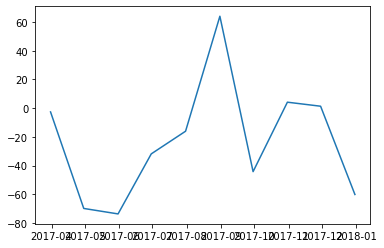

In [24]:
plt.plot(DF.Error)

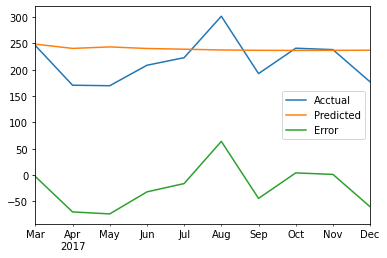

In [37]:
DF.plot();

### Perform the LJung-Box test

In [25]:
# LJung-Box test
pvalue = sm.stats.acorr_ljungbox(m1.resid,lags=[1],return_df=True)['lb_pvalue'].values
if pvalue < 0.05:
    print("Reject H0. Bad model")
else:
    print("Fail-to-Reject H0. Good model")

Fail-to-Reject H0. Good model


### Calculate MSE and RMSE of the Model from the test

In [26]:
# MSE
msg = 'ARMA Model. Order=(' + str(5) + ',' + str(3) + ')'
mse1 = mean_squared_error(DF.Acctual, DF.Predicted)
print(msg + "\n\tMSE = {}\n\tRMSE = {}".format(mse1,np.sqrt(mse1)))

ARMA Model. Order=(5,3)
	MSE = 2126.3897103448735
	RMSE = 46.112793347886374


# Visualizing actual, predicted and forcasted data

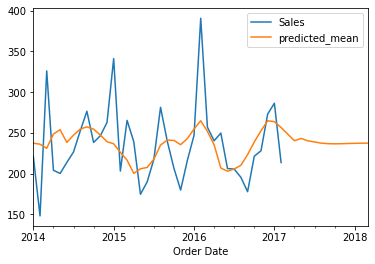

In [35]:
train.plot()
m2.predict(start=0, end=50).plot();
plt.legend()